# Notebook with training BNN on synthetic data

## Synthetic data

In [0]:
!pip install pyro-ppl gpflow

     |████████████████████████████████| 522kB 6.4MB/s 
     |████████████████████████████████| 235kB 20.6MB/s 


In [0]:
import numpy as np
import pandas as pd
from functools import partial
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import pyro
from pyro.distributions import Normal, Categorical, Delta
from pyro.infer import SVI, Trace_ELBO, TraceMeanField_ELBO
from pyro.optim import Adam
from pyro import poutine
from pyro.infer.abstract_infer import EmpiricalMarginal, TracePosterior, TracePredictive
import pyro.distributions as dist
import pyro.contrib.bnn as bnn
import matplotlib.pyplot as plt
import random
import gpflow
import tensorflow as tf
from api.data_sampling import (gaussian_sampler_2d, 
                               gaussian_data_sampling,
                               gaussian_mixture_data_sampling,
                               plot_2d_data,
                               plot_1d_label_data,
                               plot_variance_and_mean)

## Constants

In [0]:
num_hidden_neurons = 50
sigma_b = 1.0
mean = 0.0
sigma_w = [4.0, 3.0, 2.25, 2.0, 2.0, 1.9, 1.75, 1.75, 1.7, 1.65]
sigma_likelihood = 0.1

## Example of training BNN, classification

In [0]:
class NN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        output = self.fc1(x)
        output = F.relu(output)
        output = self.out(output)
        return output

train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('mnist-data/', train=True, download=True,
                       transform=transforms.Compose([transforms.ToTensor(),])),
        batch_size=128, shuffle=True)

test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('mnist-data/', train=False, transform=transforms.Compose([transforms.ToTensor(),])
                       ),
        batch_size=128, shuffle=True)

net = NN(28*28, 1024, 10)

Extracting mnist-data/MNIST/raw/train-images-idx3-ubyte.gz


Extracting mnist-data/MNIST/raw/train-labels-idx1-ubyte.gz


Extracting mnist-data/MNIST/raw/t10k-images-idx3-ubyte.gz


Extracting mnist-data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


Done!


In [0]:
log_softmax = nn.LogSoftmax(dim=1)

def model(x_data, y_data):
    
    fc1w_prior = Normal(loc=torch.zeros_like(net.fc1.weight), scale=torch.ones_like(net.fc1.weight))
    fc1b_prior = Normal(loc=torch.zeros_like(net.fc1.bias), scale=torch.ones_like(net.fc1.bias))
    
    outw_prior = Normal(loc=torch.zeros_like(net.out.weight), scale=torch.ones_like(net.out.weight))
    outb_prior = Normal(loc=torch.zeros_like(net.out.bias), scale=torch.ones_like(net.out.bias))
    
    priors = {'fc1.weight': fc1w_prior, 'fc1.bias': fc1b_prior,  
              'out.weight': outw_prior, 'out.bias': outb_prior}
    
    # lift module parameters to random variables sampled from the priors
    lifted_module = pyro.random_module("module", net, priors)
    # sample a regressor (which also samples w and b)
    lifted_reg_model = lifted_module()
    
    lhat = log_softmax(lifted_reg_model(x_data))
    
    pyro.sample("obs", Categorical(logits=lhat), obs=y_data)

In [0]:
softplus = torch.nn.Softplus()

def guide(x_data, y_data):
    
    # First layer weight distribution priors
    fc1w_mu = torch.randn_like(net.fc1.weight)
    fc1w_sigma = torch.randn_like(net.fc1.weight)
    fc1w_mu_param = pyro.param("fc1w_mu", fc1w_mu)
    fc1w_sigma_param = softplus(pyro.param("fc1w_sigma", fc1w_sigma))
    fc1w_prior = Normal(loc=fc1w_mu_param, scale=fc1w_sigma_param)
    # First layer bias distribution priors
    fc1b_mu = torch.randn_like(net.fc1.bias)
    fc1b_sigma = torch.randn_like(net.fc1.bias)
    fc1b_mu_param = pyro.param("fc1b_mu", fc1b_mu)
    fc1b_sigma_param = softplus(pyro.param("fc1b_sigma", fc1b_sigma))
    fc1b_prior = Normal(loc=fc1b_mu_param, scale=fc1b_sigma_param)
    # Output layer weight distribution priors
    outw_mu = torch.randn_like(net.out.weight)
    outw_sigma = torch.randn_like(net.out.weight)
    outw_mu_param = pyro.param("outw_mu", outw_mu)
    outw_sigma_param = softplus(pyro.param("outw_sigma", outw_sigma))
    outw_prior = Normal(loc=outw_mu_param, scale=outw_sigma_param).independent(1)
    # Output layer bias distribution priors
    outb_mu = torch.randn_like(net.out.bias)
    outb_sigma = torch.randn_like(net.out.bias)
    outb_mu_param = pyro.param("outb_mu", outb_mu)
    outb_sigma_param = softplus(pyro.param("outb_sigma", outb_sigma))
    outb_prior = Normal(loc=outb_mu_param, scale=outb_sigma_param)
    priors = {'fc1.weight': fc1w_prior, 'fc1.bias': fc1b_prior, 'out.weight': outw_prior, 'out.bias': outb_prior}
    
    lifted_module = pyro.random_module("module", net, priors)
    
    return lifted_module()

In [0]:
optim = Adam({"lr": 0.01})
svi = SVI(model, guide, optim, loss=Trace_ELBO())

In [0]:
num_iterations = 5

for j in range(num_iterations):
    loss = 0
    for batch_id, data in enumerate(train_loader):
        # calculate the loss and take a gradient step
        loss += svi.step(data[0].view(-1,28*28), data[1])
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = loss / normalizer_train
    
    print("Epoch ", j, " Loss ", total_epoch_loss_train)

/usr/lib/python3.8/site-packages/pyro/primitives.py:345: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  warnings.warn("The `random_module` primitive is deprecated, and will be removed "


Epoch  0  Loss  2107.1220911803402
Epoch  1  Loss  380.54651705376307
Epoch  2  Loss  161.62863537081083
Epoch  3  Loss  112.13573915656407
Epoch  4  Loss  96.76344890074729


In [0]:
num_samples = 10
def predict(x):
    sampled_models = [guide(None, None) for _ in range(num_samples)]
    yhats = [model(x).data for model in sampled_models]
    mean = torch.mean(torch.stack(yhats), 0)
    return torch.argmax(mean, axis=1)

print('Prediction when network is forced to predict')
correct = 0
total = 0
for j, data in enumerate(test_loader):
    images, labels = data
    predicted = predict(images.view(-1,28*28))
    total += labels.size(0).float()
    correct += (predicted == labels).sum().item()
print("accuracy: %d %%" % (100 * correct / total))

Prediction when network is forced to predict
accuracy: 88 %


In [0]:
classes = ('0', '1', '2', '3',
           '4', '5', '6', '7', '8', '9')

In [0]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    #plt.imshow(npimg,  cmap='gray')
    #fig.show(figsize=(1,1))
    
    fig, ax = plt.subplots(figsize=(1, 1))
    ax.imshow(npimg,  cmap='gray', interpolation='nearest')
    plt.show()

In [0]:
num_samples = 100
def give_uncertainities(x):
    sampled_models = [guide(None, None) for _ in range(num_samples)]
    yhats = [F.log_softmax(model(x.view(-1,28*28)).data, 1).detach().numpy() for model in sampled_models]
    return np.asarray(yhats)

In [0]:
def test_batch(images, labels, plot=True):
    y = give_uncertainities(images)
    predicted_for_images = 0
    correct_predictions = 0

    for i in range(len(labels)):
    
        if(plot):
            print("Real: ",labels[i].item())
            fig, axs = plt.subplots(1, 10, sharey=True,figsize=(20,2))
    
        all_digits_prob = []
    
        highted_something = False
    
        for j in range(len(classes)):
        
            highlight=False
        
            histo = []
            histo_exp = []
        
            for z in range(y.shape[0]):
                histo.append(y[z][i][j])
                histo_exp.append(np.exp(y[z][i][j]))
            
            prob = np.percentile(histo_exp, 50) #sampling median probability
        
            if(prob>0.2): #select if network thinks this sample is 20% chance of this being a label
                highlight = True #possibly an answer
        
            all_digits_prob.append(prob)
            
            if(plot):
            
                N, bins, patches = axs[j].hist(histo, bins=8, color = "lightgray", lw=0,  weights=np.ones(len(histo)) / len(histo), density=False)
                axs[j].set_title(str(j)+" ("+str(round(prob,2))+")") 
        
            if(highlight):
            
                highted_something = True
                
                if(plot):

                    # We'll color code by height, but you could use any scalar
                    fracs = N / N.max()

                    # we need to normalize the data to 0..1 for the full range of the colormap
                    norm = colors.Normalize(fracs.min(), fracs.max())

                    # Now, we'll loop through our objects and set the color of each accordingly
                    for thisfrac, thispatch in zip(fracs, patches):
                        color = plt.cm.viridis(norm(thisfrac))
                        thispatch.set_facecolor(color)

    
        if(plot):
            plt.show()
    
        predicted = np.argmax(all_digits_prob)
    
        if(highted_something):
            predicted_for_images+=1
            if(labels[i].item()==predicted):
                if(plot):
                    print("Correct")
                correct_predictions +=1.0
            else:
                if(plot):
                    print("Incorrect :()")
        else:
            if(plot):
                print("Undecided.")
        
        if(plot):
            imshow(images[i].squeeze())
        
    
    if(plot):
        print("Summary")
        print("Total images: ",len(labels))
        print("Predicted for: ",predicted_for_images)
        print("Accuracy when predicted: ",correct_predictions/predicted_for_images)
        
    return len(labels), correct_predictions, predicted_for_images

In [0]:
print('Prediction when network can refuse')
correct = 0
total = 0
total_predicted_for = 0
for j, data in enumerate(test_loader):
    images, labels = data
    
    total_minibatch, correct_minibatch, predictions_minibatch = test_batch(images, labels, plot=False)
    total += total_minibatch
    correct += correct_minibatch
    total_predicted_for += predictions_minibatch

print("Total images: ", total)
print("Skipped: ", total-total_predicted_for)
print("Accuracy when made predictions: %d %%" % (100 * correct / total_predicted_for))

Prediction when network can refuse
Total images:  10000
Skipped:  1347
Accuracy when made predictions: 95 %


## Synthetic 1D data and fitting GP

In [0]:
gaussian_centers = torch.Tensor([[-1.0/(2**0.5)], [1.0/(2**0.5)]])
data_num = 100
data_sigma_noise = 0.1
sigma = 0.01
init_cov_matrix = torch.eye(1)
cov_matrix_default = sigma*init_cov_matrix
seed = 42
data_1d = gaussian_mixture_data_sampling(gaussian_centers, cov_matrix_default, 
                                         data_num, seed)

In [0]:
def model_1d(data):
    real_labels = torch.sin(12*data) + 0.66*torch.cos(25*data) + 3
    return real_labels

def noise_labels_model(real_labels, sigma_noise, seed = None):
    loc = 0.   # mean zero
    scale = 1.
    normal = torch.distributions.Normal(loc, scale) # create a normal distribution object
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
    x = normal.rsample([real_labels.shape[0]]) 
    real_labels = real_labels + x*sigma_noise
    return real_labels

real_labels = model_1d(data_1d[:, 0])
noise_labels =  noise_labels_model(real_labels, sigma_noise = data_sigma_noise, seed = seed).reshape((real_labels.shape[0], 1))
range_for_real_labels = torch.linspace(-1, 1, steps = 1000)
real_labels_range = model_1d(range_for_real_labels)

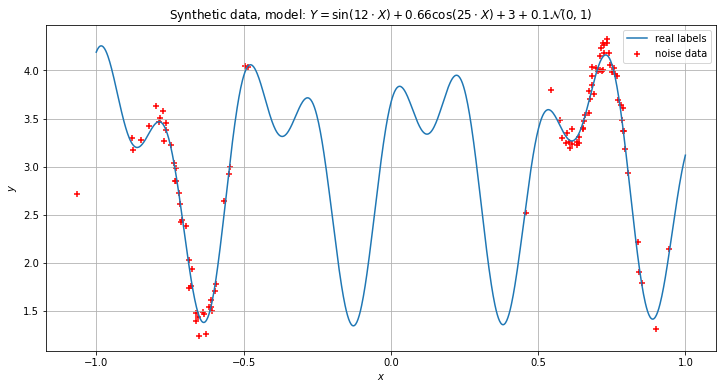

In [0]:
model_name = r'$Y = \sin(12 \cdot X) + 0.66\cos(25 \cdot X) + 3 + 0.1 \mathcal{N}(0, 1)$'
plot_1d_label_data(data_1d[:, 0], range_for_real_labels, real_labels_range, 
                   noise_labels[:, 0], model_name, figsize = (12, 6))

In [0]:
k = gpflow.kernels.Matern52(1, lengthscales=0.3)
gp = gpflow.models.GPR(data=(data_1d, noise_labels), kernel=k, mean_function=None)
gp.likelihood.variance.assign(0.01)
gp.kernel.lengthscales.assign(0.3)

<tf.Variable 'UnreadVariable' shape=() dtype=float64, numpy=-1.0502256128148466>

In [0]:
opt = gpflow.optimizers.Scipy()

In [0]:
opt_logs = opt.minimize(gp.training_loss, gp.trainable_variables, options=dict(maxiter=100))

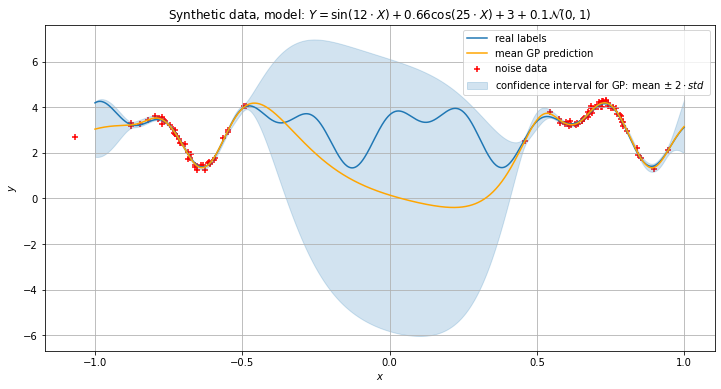

In [0]:
## predict mean and variance of latent GP at test points
xx = np.asarray(range_for_real_labels.reshape(1000, 1).numpy(), 
                dtype = 'float64')
#xx = np.linspace(-0.1, 1.1, 100).reshape(100, 1)
mean, var = gp.predict_f(xx)

plot_1d_label_data(data = data_1d[:, 0], 
                   range_for_real_labels = range_for_real_labels, 
                   real_labels = real_labels_range, 
                   noise_labels = noise_labels[:, 0], 
                   model_name = model_name, figsize = (12, 6),
                   range_for_prediction = xx[:, 0],
                   mean_prediction = mean[:, 0],
                   var_prediction = var[:, 0],
                   model_prediction_name = 'GP')

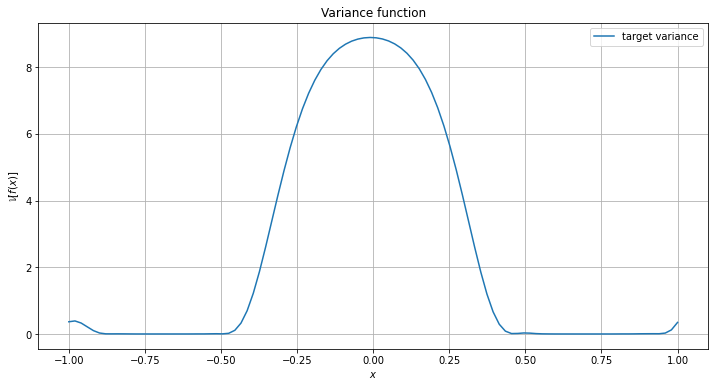

In [0]:
N = 100
grid = np.linspace(-1, 1, num = N).reshape((N, 1))
mean_gp_grid, var_gp_grid = np.array(gp.predict_f(grid))
plot_variance_and_mean(grid[:, 0], target_variance = var_gp_grid[:, 0])

## Training BNN on regression task, example

In [0]:
class RegressionModel(nn.Module):
    def __init__(self, num_feature, num_hidden): 
        super().__init__()
        self.fc1 = nn.Linear(num_feature, num_hidden)
        self.out = nn.Linear(num_hidden, 2)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        out = self.out(x)
        return out

num_hidden = 50 #hidden units
num_feature = 1  #num input dimensions
net = RegressionModel(num_feature, num_hidden)
net = net.cuda()

In [66]:
torch_grid = torch.Tensor(grid).cuda()
a = net(torch_grid)
print(a.shape)

torch.Size([100, 2])


In [80]:
def model(x_data, y_data):
    # weight and bias priors
    w1_prior = Normal(loc = torch.zeros_like(net.fc1.weight), 
                    scale = torch.ones_like(net.fc1.weight)).independent(2)
    b1_prior = Normal(loc = torch.zeros_like(net.fc1.bias),
                    scale = torch.ones_like(net.fc1.bias)).independent(1)

    wout_prior = Normal(loc=torch.zeros_like(net.out.weight), 
                        scale=torch.ones_like(net.out.weight)).independent(2)
    bout_prior = Normal(loc=torch.zeros_like(net.out.bias), 
                      scale=torch.ones_like(net.out.bias)).independent(1)

    priors = {'fc1.weight': w1_prior, 'fc1.bias': b1_prior, 
              'out.weight': wout_prior,'out.bias': bout_prior}
    # lift module parameters from neural net
    lifted_module = pyro.random_module("module", net, priors)
    lifted_reg_model = lifted_module()
    with pyro.plate("map", len(x_data)):
        #run forward on regression_model
        prediction = lifted_reg_model(x_data)
        prediction_mean = prediction[:, 0]
        softplus = torch.nn.Softplus()
        prediction_var = softplus(prediction[:, 1])
        prediction_std = torch.pow(prediction_var, 0.5)
        # condition on the observed data
        pyro.sample("obs", Normal(prediction_mean, prediction_std), obs = y_data)
        return prediction_mean

mean_gp, var_gp = gp.predict_f(grid)
torch_grid = torch.Tensor(grid).cuda()
torch_gp_pred_mean = torch.Tensor(np.array(mean_gp)).cuda()
test = model(torch_grid, torch_gp_pred_mean)

/usr/local/lib/python3.6/dist-packages/pyro/primitives.py:406: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  "modules from `torch.nn.Module` instances.", FutureWarning)


In [0]:
def guide(x_data, y_data):
    softplus = torch.nn.Softplus()
    # First layer weight distribution priors
    fc1w_mu = torch.randn_like(net.fc1.weight)
    fc1w_sigma = torch.randn_like(net.fc1.weight)
    fc1w_mu_param = pyro.param("fc1w_mu", fc1w_mu)
    fc1w_sigma_param = softplus(pyro.param("fc1w_sigma", fc1w_sigma))
    fc1w_prior = Normal(loc=fc1w_mu_param, scale=fc1w_sigma_param)
    # First layer bias distribution priors
    fc1b_mu = torch.randn_like(net.fc1.bias)
    fc1b_sigma = torch.randn_like(net.fc1.bias)
    fc1b_mu_param = pyro.param("fc1b_mu", fc1b_mu)
    fc1b_sigma_param = softplus(pyro.param("fc1b_sigma", fc1b_sigma))
    fc1b_prior = Normal(loc=fc1b_mu_param, scale=fc1b_sigma_param)
    # Output layer weight distribution priors
    outw_mu = torch.randn_like(net.out.weight)
    outw_sigma = torch.randn_like(net.out.weight)
    outw_mu_param = pyro.param("outw_mu", outw_mu)
    outw_sigma_param = softplus(pyro.param("outw_sigma", outw_sigma))
    outw_prior = Normal(loc = outw_mu_param, scale = outw_sigma_param).independent(1)
    # Output layer bias distribution priors
    outb_mu = torch.randn_like(net.out.bias)
    outb_sigma = torch.randn_like(net.out.bias)
    outb_mu_param = pyro.param("outb_mu", outb_mu)
    outb_sigma_param = softplus(pyro.param("outb_sigma", outb_sigma))
    outb_prior = Normal(loc=outb_mu_param, scale=outb_sigma_param)
    priors = {'fc1.weight': fc1w_prior, 'fc1.bias': fc1b_prior, 'out.weight': outw_prior, 'out.bias': outb_prior}
    
    lifted_module = pyro.random_module("module", net, priors)
    
    return lifted_module()

In [69]:
lr = 1e-2
optim = Adam({"lr": lr})
num_samples = 128
svi = SVI(model, guide, optim, loss = Trace_ELBO(), num_samples = num_samples)
num_epoch = 80000
def loss_train(X, y, num_epoch):
    pyro.clear_param_store()
    loss_arr = []
    for j in range(num_epoch):
        # calculate the loss and take a gradient step
        loss = svi.step(X, y)
        loss_arr.append(loss)
        if j % 50 == 0:
            print("[iteration %04d] loss: %.4f" % (j + 1, loss))
    return loss_arr

/usr/local/lib/python3.6/dist-packages/pyro/infer/svi.py:53: FutureWarning: The `num_samples` argument to SVI is deprecated and will be removed in a future release. Use `pyro.infer.Predictive` class to draw samples from the posterior.
  'samples from the posterior.', FutureWarning)


In [70]:
torch_gp_pred_mean = torch.Tensor(np.array(mean_gp)).cuda()
loss_arr = loss_train(X = torch_grid, y = torch_gp_pred_mean, num_epoch = num_epoch)

/usr/local/lib/python3.6/dist-packages/pyro/primitives.py:406: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  "modules from `torch.nn.Module` instances.", FutureWarning)


[iteration 0001] loss: 389685051550.0140
[iteration 0051] loss: 28091.0479
[iteration 0101] loss: 1160061.3679
[iteration 0151] loss: 42840052.0440
[iteration 0201] loss: 117660.8019
[iteration 0251] loss: 31745.7552
[iteration 0301] loss: 56648.4985
[iteration 0351] loss: 452403.4986
[iteration 0401] loss: 88484.0795
[iteration 0451] loss: 163829196.5076
[iteration 0501] loss: 116560.2638
[iteration 0551] loss: 34764.6119
[iteration 0601] loss: 56018.0822
[iteration 0651] loss: 42088.1897
[iteration 0701] loss: 2112303.2793
[iteration 0751] loss: 41784.7459
[iteration 0801] loss: 51898.6681
[iteration 0851] loss: 26362.1074
[iteration 0901] loss: 24505.1030
[iteration 0951] loss: 144961.1073
[iteration 1001] loss: 65478.1239
[iteration 1051] loss: 49830.7532
[iteration 1101] loss: 34809.2677
[iteration 1151] loss: 26212.6052
[iteration 1201] loss: 61096.3869
[iteration 1251] loss: 72545.5097
[iteration 1301] loss: 24470.5120
[iteration 1351] loss: 44116.3479
[iteration 1401] loss: 756

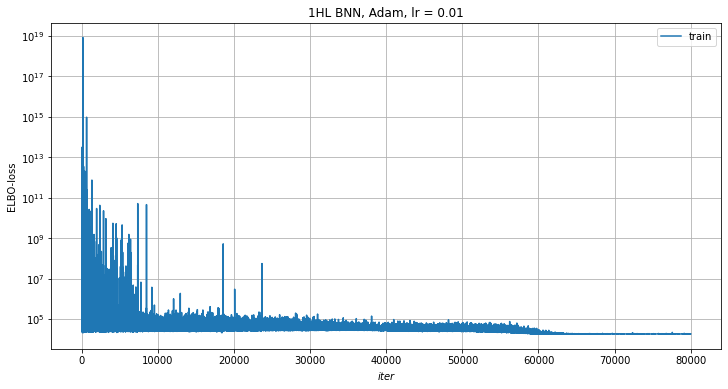

In [71]:
fig = plt.figure(figsize = (12, 6))

plt.xlabel(r'$iter$') 
plt.ylabel(r'ELBO-loss') 
plt.title(fr'1HL BNN, Adam, lr = {lr}') 

plt.plot(range(len(loss_arr)), loss_arr, label = 'train')
plt.yscale("log")
plt.legend()
plt.grid(True)
plt.show() 

In [76]:
get_marginal = lambda traces, sites: EmpiricalMarginal(traces, sites)._get_samples_and_weights()[0].detach().cpu().numpy()
def summary(traces, sites):
    marginal = get_marginal(traces, sites)
    site_stats = {}
    for i in range(marginal.shape[1]):
        site_name = sites[i]
        marginal_site = pd.DataFrame(marginal[:, i]).transpose()
        describe = partial(pd.Series.describe, percentiles=[.05, 0.25, 0.5, 0.75, 0.95])
        site_stats[site_name] = marginal_site.apply(describe, axis=1)[["mean", "std", "5%", "25%", "50%", "75%", "95%"]]
    return site_stats

def wrapped_model(x_data, y_data):
    pyro.sample("prediction", Delta(model(x_data, y_data)))

posterior = svi.run(torch_grid, torch_gp_pred_mean)
trace_pred = TracePredictive(wrapped_model, posterior, num_samples = 1000)
post_pred = trace_pred.run(torch_grid, None)
post_summary = summary(post_pred, sites= ['prediction', 'obs'])
mu = post_summary["prediction"]
y_o = post_summary["obs"]
predictions = pd.DataFrame({"grid": grid[:, 0], "mu_mean": mu["mean"], "mu_std": mu["std"],
                            "y_mean": y_o["mean"], "y_std": y_o["std"],"true_y": np.array(mean_gp)[:, 0]})

/usr/local/lib/python3.6/dist-packages/pyro/infer/svi.py:89: FutureWarning: The `SVI.run` method is deprecated and will be removed in a future release. For inference, use `SVI.step` directly, and for predictions, use the `pyro.infer.Predictive` class.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/pyro/primitives.py:406: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  "modules from `torch.nn.Module` instances.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/pyro/infer/abstract_infer.py:299: FutureWarning: The `TracePredictive` class is deprecated and will be removed in a future release. Use the `pyro.infer.Predictive` class instead.
  FutureWarning)


In [77]:
predictions

,grid,mu_mean,mu_std,y_mean,y_std,true_y
0,-1.000000,2.104840,0.108024,2.173212,1.473739,3.039873
1,-0.979798,2.104272,0.102458,2.134779,1.500281,3.100753
2,-0.959596,2.103442,0.097399,2.035181,1.529934,3.145289
3,-0.939394,2.102685,0.092818,2.153152,1.485091,3.175058
4,-0.919192,2.102010,0.088533,2.063717,1.429573,3.193072
...,...,...,...,...,...,...
95,0.919192,2.098161,0.096164,2.109541,1.442731,1.587230
96,0.939394,2.098296,0.100803,2.116078,1.490314,1.973092
97,0.959596,2.098636,0.105739,2.102798,1.479462,2.413686
98,0.979798,2.098923,0.110866,2.145717,1.497614,2.822486


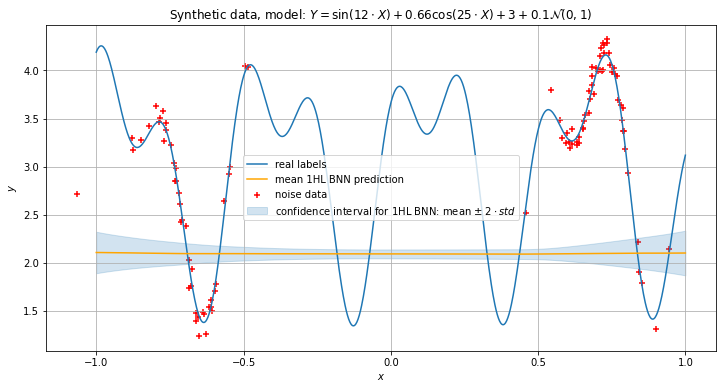

In [78]:
model_name = r'$Y = \sin(12 \cdot X) + 0.66\cos(25 \cdot X) + 3 + 0.1 \mathcal{N}(0, 1)$'
plot_1d_label_data(data = data_1d[:, 0], 
                   range_for_real_labels = range_for_real_labels, 
                   real_labels = real_labels_range, 
                   noise_labels = noise_labels[:, 0], 
                   model_name = model_name, figsize = (12, 6),
                   range_for_prediction = grid[:, 0],
                   mean_prediction = np.array(mu["mean"]),
                   var_prediction = np.power(np.array(mu["std"]), 2.0),
                   model_prediction_name = '1HL BNN')

In [88]:
num_hidden = 50 #hidden units
num_feature = 1  #num input dimensions
net = RegressionModel(num_feature, num_hidden)
net = net.cuda()
torch_grid = torch.Tensor(data_1d).cuda()
torch_noise_labels = torch.Tensor(noise_labels).cuda()
lr = 1e-2
optim = Adam({"lr": lr})
num_samples = 128
svi = SVI(model, guide, optim, loss = Trace_ELBO(), num_samples = num_samples)
num_epoch = 80000

/usr/local/lib/python3.6/dist-packages/pyro/infer/svi.py:53: FutureWarning: The `num_samples` argument to SVI is deprecated and will be removed in a future release. Use `pyro.infer.Predictive` class to draw samples from the posterior.
  'samples from the posterior.', FutureWarning)


In [89]:
loss_arr = loss_train(X = torch_grid, y = torch_noise_labels, num_epoch = num_epoch)

/usr/local/lib/python3.6/dist-packages/pyro/primitives.py:406: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  "modules from `torch.nn.Module` instances.", FutureWarning)


[iteration 0001] loss: 437372682433.8115
[iteration 0051] loss: 21507.3351
[iteration 0101] loss: 17244.7462
[iteration 0151] loss: 103340771.4433
[iteration 0201] loss: 1934496022.3086
[iteration 0251] loss: 23844.8879
[iteration 0301] loss: 5077364.2662
[iteration 0351] loss: 25235.2423
[iteration 0401] loss: 3251453.5407
[iteration 0451] loss: 1523608.4921
[iteration 0501] loss: 59572650.8209
[iteration 0551] loss: 196517.7001
[iteration 0601] loss: 203627.8830
[iteration 0651] loss: 219596.2153
[iteration 0701] loss: 24456.7650
[iteration 0751] loss: 25492808.8517
[iteration 0801] loss: 651921.6476
[iteration 0851] loss: 100188.0287
[iteration 0901] loss: 14815336.3327
[iteration 0951] loss: 218804.0018
[iteration 1001] loss: 89385.0518
[iteration 1051] loss: 88691.7802
[iteration 1101] loss: 41131.0294
[iteration 1151] loss: 108657.8798
[iteration 1201] loss: 24526.0462
[iteration 1251] loss: 296901.8297
[iteration 1301] loss: 209427.9424
[iteration 1351] loss: 62185.0047
[iterati

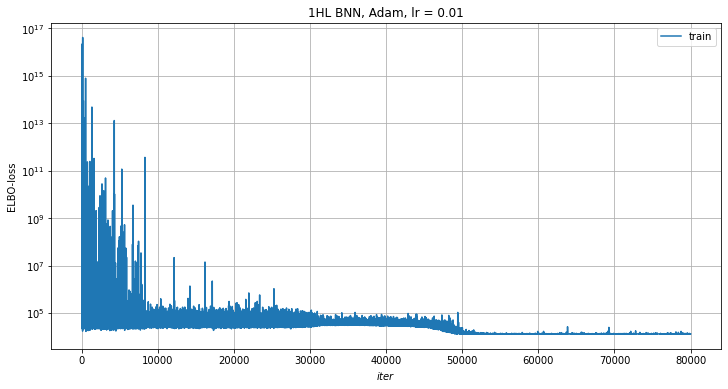

In [90]:
fig = plt.figure(figsize = (12, 6))

plt.xlabel(r'$iter$') 
plt.ylabel(r'ELBO-loss') 
plt.title(fr'1HL BNN, Adam, lr = {lr}') 

plt.plot(range(len(loss_arr)), loss_arr, label = 'train')
plt.yscale("log")
plt.legend()
plt.grid(True)
plt.show() 

In [91]:
get_marginal = lambda traces, sites: EmpiricalMarginal(traces, sites)._get_samples_and_weights()[0].detach().cpu().numpy()
def summary(traces, sites):
    marginal = get_marginal(traces, sites)
    site_stats = {}
    for i in range(marginal.shape[1]):
        site_name = sites[i]
        marginal_site = pd.DataFrame(marginal[:, i]).transpose()
        describe = partial(pd.Series.describe, percentiles=[.05, 0.25, 0.5, 0.75, 0.95])
        site_stats[site_name] = marginal_site.apply(describe, axis=1)[["mean", "std", "5%", "25%", "50%", "75%", "95%"]]
    return site_stats

def wrapped_model(x_data, y_data):
    pyro.sample("prediction", Delta(model(x_data, y_data)))

posterior = svi.run(torch_grid, torch_gp_pred_mean)
trace_pred = TracePredictive(wrapped_model, posterior, num_samples = 1000)
post_pred = trace_pred.run(torch_grid, None)
post_summary = summary(post_pred, sites= ['prediction', 'obs'])
mu = post_summary["prediction"]
y_o = post_summary["obs"]
predictions = pd.DataFrame({"grid": grid[:, 0], "mu_mean": mu["mean"], "mu_std": mu["std"],
                            "y_mean": y_o["mean"], "y_std": y_o["std"],"true_y": np.array(mean_gp)[:, 0]})

/usr/local/lib/python3.6/dist-packages/pyro/infer/svi.py:89: FutureWarning: The `SVI.run` method is deprecated and will be removed in a future release. For inference, use `SVI.step` directly, and for predictions, use the `pyro.infer.Predictive` class.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/pyro/primitives.py:406: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  "modules from `torch.nn.Module` instances.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/pyro/infer/abstract_infer.py:299: FutureWarning: The `TracePredictive` class is deprecated and will be removed in a future release. Use the `pyro.infer.Predictive` class instead.
  FutureWarning)


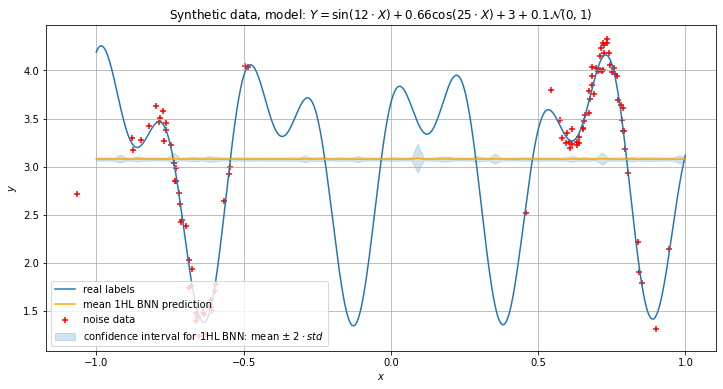

In [92]:
model_name = r'$Y = \sin(12 \cdot X) + 0.66\cos(25 \cdot X) + 3 + 0.1 \mathcal{N}(0, 1)$'
plot_1d_label_data(data = data_1d[:, 0], 
                   range_for_real_labels = range_for_real_labels, 
                   real_labels = real_labels_range, 
                   noise_labels = noise_labels[:, 0], 
                   model_name = model_name, figsize = (12, 6),
                   range_for_prediction = grid[:, 0],
                   mean_prediction = np.array(mu["mean"]),
                   var_prediction = np.power(np.array(mu["std"]), 2.0),
                   model_prediction_name = '1HL BNN')

## Training 1HL BNN 

In [0]:
softplus = torch.nn.Softplus()
features = torch.Tensor(grid)
input_size = 1
n_hidden = 50
kl_factor = 1.0
n_features = features.size(0)
labels = torch.Tensor(np.stack((mean_gp_grid, var_gp_grid), axis=1)).view(n_features, 2)
# Set-up parameters for the distribution of weights for each layer `a<n>`
a1_mean = torch.zeros(input_size, n_hidden)
a1_scale = torch.ones(input_size, n_hidden) 
a2_mean = torch.zeros(n_hidden + 1, 2)
a2_scale = torch.ones(n_hidden + 1, 2)
# Mark batched calculations to be conditionally independent given parameters using `plate`
with pyro.plate('data', size = n_features):
    # Sample first hidden layer
    h1 = pyro.sample('h1', bnn.HiddenLayer(features, a1_mean,  a1_scale, 
                                            KL_factor = kl_factor))
    # Sample output 
    print(h1.shape)
    output = pyro.sample('bnn_output', bnn.HiddenLayer(h1, a2_mean, a2_scale,
                                                    non_linearity=lambda x: x,
                                                    KL_factor=kl_factor, include_hidden_bias = False))
    mu_output = output[:, 0]
    sigma_inv_softplus_output = output[:, 1]
    sigma_output = softplus(sigma_inv_softplus_output)
    ans = pyro.sample('label', Normal(loc = mu_output, scale = sigma_output)) 

torch.Size([100, 51])


In [0]:
ans.shape

torch.Size([100])

In [0]:
from __future__ import absolute_import, division, print_function

import torch

import pyro
import pyro.poutine as poutine
from pyro.infer.elbo import ELBO
from pyro.infer.util import torch_item

def model(features, labels = None, kl_factor=1.0): 
    n_features = features.size(0)
    n_hidden = 50
    input_size = 1
    # Set-up parameters for the distribution of weights for each layer `a<n>`
    a1_mean = torch.zeros(input_size, n_hidden)
    a1_scale = torch.ones(input_size, n_hidden) 
    a2_mean = torch.zeros(n_hidden + 1, 2)
    a2_scale = torch.ones(n_hidden + 1, 2)
    # Mark batched calculations to be conditionally independent given parameters using `plate`
    with pyro.plate('data', size = n_features):
        # Sample first hidden layer
        h1 = pyro.sample('h1', bnn.HiddenLayer(features, a1_mean,  a1_scale, 
                                                KL_factor = kl_factor))
        # Sample output 
        output = pyro.sample('bnn_output', bnn.HiddenLayer(h1, a2_mean, a2_scale,
                                                        non_linearity=lambda x: x,
                                                        KL_factor=kl_factor, include_hidden_bias = False))
        mu_output = output[:, 0]
        sigma_inv_softplus_output = output[:, 1]
        sigma_output = softplus(sigma_inv_softplus_output)
        return mu_output, sigma_output
        #return pyro.sample('label', Normal(loc = mu_output, scale = sigma_output)) 

def guide(features, labels=None, kl_factor=1.0):
    n_features = features.size(0)
    n_hidden = 50
    input_size = 1
    # Set-up parameters to be optimized to approximate the true posterior
    a1_mean = pyro.param('a1_mean', torch.randn(input_size, n_hidden))
    a1_scale = softplus(pyro.param('a1_scale', torch.randn(input_size, n_hidden)))

    a2_mean = pyro.param('a2_mean', torch.randn(n_hidden + 1, n_hidden))
    a2_scale = softplus(pyro.param('a2_scale', torch.randn(n_hidden + 1, n_hidden)))

    # Sample latent values using the variational parameters that are set-up above.
    # Notice how there is no conditioning on labels in the guide!
    with pyro.plate('data', size = n_features):
        # Sample first hidden layer
        h1 = pyro.sample('h1', bnn.HiddenLayer(features, a1_mean,  a1_scale, 
                                                KL_factor = kl_factor))
        # Sample output 
        output = pyro.sample('bnn_output', bnn.HiddenLayer(h1, a2_mean, a2_scale,
                                                        non_linearity=lambda x: x,
                                                        KL_factor=kl_factor, include_hidden_bias = False))
        mu_output = output[:, 0]
        sigma_inv_softplus_output = output[:, 1]
        sigma_output = softplus(sigma_inv_softplus_output)
        #return pyro.sample('label', Normal(loc = mu_output, scale = sigma_output)) 
        return mu_output, sigma_output

def simple_elbo(model, guide, *args, **kwargs):
    # run the guide and trace its execution
    guide_trace = poutine.trace(guide).get_trace(*args, **kwargs)
    # run the model and replay it against the samples from the guide
    model_trace = poutine.trace(
        poutine.replay(model, trace=guide_trace)).get_trace(*args, **kwargs)
    # construct the elbo loss function
    return -1*(model_trace.log_prob_sum() - guide_trace.log_prob_sum())

def l2_loss_between_GP(mean_true, var_true, mean_pred_mc, var_pred_mc):
    loss = nn.MSELoss(reduction = 'sum')
    return loss(mean_true, mean_pred_mc) + loss(mean_pred_mc, var_pred_mc)

def my_l2_loss(model, guide, *args, **kwargs):
    # run the guide and trace its execution
    X, num_samples, gp, kl_factor = args
    X_torch = torch.Tensor(X)
    sampled_means_and_vars = [guide(X_torch, kl_factor = kl_factor) for _ in range(num_samples)]
    means_predictions = [sampled_mean_and_var[0].data for sampled_mean_and_var in sampled_means_and_vars]
    var_predictions = [sampled_mean_and_var[1].data for sampled_mean_and_var in sampled_means_and_vars]
    mean = torch.mean(torch.stack(means_predictions), 0)
    var = torch.mean(torch.stack(var_predictions), 0)
    mean_gp, var_gp = np.array(gp.predict_f(X))  
    mean_gp_torch = torch.Tensor(mean_gp[:, 0])
    var_gp_torch = torch.Tensor(var_gp[:, 0])
    return l2_loss_between_GP(mean_gp_torch, var_gp_torch, mean, var)

num_samples = 128
kl_factor = 1.0
loss =  my_l2_loss(model, guide, grid, num_samples, gp, kl_factor)

In [0]:
from __future__ import absolute_import, division, print_function

import torch

import pyro
import pyro.poutine as poutine
from pyro.infer.elbo import ELBO
from pyro.infer.util import torch_item


class SVI(object):
    """
    :param model: the model (callable containing Pyro primitives)
    :param guide: the guide (callable containing Pyro primitives)
    :param optim: a wrapper a for a PyTorch optimizer
    :type optim: pyro.optim.PyroOptim
    :param loss: an instance of a subclass of :class:`~pyro.infer.elbo.ELBO`.
        Pyro provides three built-in losses:
        :class:`~pyro.infer.trace_elbo.Trace_ELBO`,
        :class:`~pyro.infer.tracegraph_elbo.Trace_ELBO`, and
        :class:`~pyro.infer.traceenum_elbo.Trace_ELBO`.
        See the :class:`~pyro.infer.elbo.ELBO` docs to learn how to implement
        a custom loss.
    :type loss: pyro.infer.elbo.ELBO

    A unified interface for stochastic variational inference in Pyro. The most
    commonly used loss is ``loss=Trace_ELBO()``. See the tutorial
    `SVI Part I <http://pyro.ai/examples/svi_part_i.html>`_ for a discussion.
    """
    def __init__(self,
                 model,
                 guide,
                 optim,
                 loss,
                 loss_and_grads=None,
                 **kwargs):
        self.model = model
        self.guide = guide
        self.optim = optim

        if isinstance(loss, ELBO):
            self.loss = loss.loss
            self.loss_and_grads = loss.loss_and_grads
        else:
            if loss_and_grads is None:
                def _loss_and_grads(*args, **kwargs):
                    loss_val = loss(*args, **kwargs)
                    print("start to do backward")
                    loss_val.backward()
                    return loss_val
                loss_and_grads = _loss_and_grads
            self.loss = loss
            self.loss_and_grads = loss_and_grads

    def evaluate_loss(self, *args, **kwargs):
        """
        :returns: estimate of the loss
        :rtype: float

        Evaluate the loss function. Any args or kwargs are passed to the model and guide.
        """
        with torch.no_grad():
            return torch_item(self.loss(self.model, self.guide, *args, **kwargs))


    def step(self, *args, **kwargs):
        """
        :returns: estimate of the loss
        :rtype: float

        Take a gradient step on the loss function (and any auxiliary loss functions
        generated under the hood by `loss_and_grads`).
        Any args or kwargs are passed to the model and guide
        """
        # get loss and compute gradients
        print("start to calculate gradients")
        with poutine.trace(param_only=True) as param_capture:
            loss = self.loss_and_grads(self.model, self.guide, *args, **kwargs)

        params = set(site["value"].unconstrained()
                     for site in param_capture.trace.nodes.values())

        # actually perform gradient steps
        # torch.optim objects gets instantiated for any params that haven't been seen yet
        self.optim(params)

        # zero gradients
        pyro.infer.util.zero_grads(params)

        return torch_item(loss)

In [0]:
class BNN_1HL(nn.Module):
    def __init__(self, input_size = 1, n_hidden = 50):
        super(BNN_1HL, self).__init__()
        self.input_size = input_size
        self.n_hidden = n_hidden
       
    def model(self, features, labels = None, kl_factor=1.0): 
        n_features = features.size(0)
        # Set-up parameters for the distribution of weights for each layer `a<n>`
        a1_mean = torch.zeros(self.input_size, self.n_hidden)
        a1_scale = torch.ones(self.input_size, self.n_hidden) 
        a2_mean = torch.zeros(self.n_hidden + 1, 2)
        a2_scale = torch.ones(self.n_hidden + 1, 2)
        # Mark batched calculations to be conditionally independent given parameters using `plate`
        with pyro.plate('data', size = n_features):
            # Sample first hidden layer
            h1 = pyro.sample('h1', bnn.HiddenLayer(features, a1_mean,  a1_scale, 
                                                    KL_factor = kl_factor))
            # Sample output 
            output = pyro.sample('bnn_output', bnn.HiddenLayer(h1, a2_mean, a2_scale,
                                                            non_linearity=lambda x: x,
                                                            KL_factor=kl_factor, include_hidden_bias = False))
            mu_output = output[:, 0]
            sigma_inv_softplus_output = output[:, 1]
            sigma_output = softplus(sigma_inv_softplus_output)
            #return pyro.sample('label', Normal(loc = mu_output, scale = sigma_output), obs = labels) 
            return mu_output, sigma_output
    
    def guide(self, features, labels=None, kl_factor=1.0):
        n_features = features.size(0)
        # Set-up parameters to be optimized to approximate the true posterior
        a1_mean = pyro.param('a1_mean', torch.randn(self.input_size, self.n_hidden))
        a1_scale = softplus(pyro.param('a1_scale', torch.randn(self.input_size, self.n_hidden)))

        a2_mean = pyro.param('a2_mean', torch.randn(self.n_hidden + 1, self.n_hidden))
        a2_scale = softplus(pyro.param('a2_scale', torch.randn(self.n_hidden + 1, self.n_hidden)))

        # Sample latent values using the variational parameters that are set-up above.
        # Notice how there is no conditioning on labels in the guide!
        with pyro.plate('data', size = n_features):
            # Sample first hidden layer
            h1 = pyro.sample('h1', bnn.HiddenLayer(features, a1_mean,  a1_scale, 
                                                    KL_factor = kl_factor))
            # Sample output 
            output = pyro.sample('bnn_output', bnn.HiddenLayer(h1, a2_mean, a2_scale,
                                                            non_linearity=lambda x: x,
                                                            KL_factor=kl_factor, include_hidden_bias = False))
            mu_output = output[:, 0]
            sigma_inv_softplus_output = output[:, 1]
            sigma_output = softplus(sigma_inv_softplus_output)
            #return pyro.sample('label', Normal(loc = mu_output, scale = sigma_output)) 
            return mu_output, sigma_output
    
    def infer_parameters_to_gp(self, X, gp, lr = 1e-3, num_samples = 128,
                         num_epochs = 10):
        optimizer = Adam({'lr': lr})
        svi = SVI(self.model, self.guide, optimizer, loss = my_l2_loss)
        kl_factor = X.shape[0]
        for i in range(num_epochs):
            print("start to do job")
            loss = svi.step(X, num_samples, gp, kl_factor)
            param_store = pyro.get_param_store()
            print(f"[Epoch {i + 1}], loss: {loss:.5E}")

In [0]:
input_size = 1
n_hidden = 50
simple_BNN = BNN_1HL(input_size = input_size, n_hidden = n_hidden)

In [0]:
lr = 1e-3
num_samples = 128
num_epochs = 10
simple_BNN.infer_parameters_to_gp(X = grid, gp = gp, lr = lr, 
                                  num_samples = num_samples, num_epochs = 10)

start to do job
start to calculate gradients
start to do bacward


RuntimeError: ignored

In [0]:
def predict(X, guide, mc_num_estimations, seed = None):
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
    sampled_models = [guide(None, None) for _ in range(mc_num_estimations)]
    predictions = [model(X) for model in sampled_models]
    means_predictions = [predictions[:, 0].data for prediction in predictions]
    inv_softplus_var_predictions = [predictions[:, 1].data for prediction in predictions]
    mean = torch.mean(torch.stack(means_predictions), 0)
    inv_softplus_var = torch.mean(torch.stack(inv_softplus_var_predictions), 0)
    return mean, inv_softplus_var

def simple_elbo(model, guide, *args, **kwargs):
    # run the guide and trace its execution
    guide_trace = poutine.trace(guide).get_trace(*args, **kwargs)
    # run the model and replay it against the samples from the guide
    model_trace = poutine.trace(
        poutine.replay(model, trace=guide_trace)).get_trace(*args, **kwargs)
    # construct the elbo loss function
    return -1*(model_trace.log_prob_sum() - guide_trace.log_prob_sum())


In [0]:
def train_simple_BNN(num_epochs, BNN, baseline_model, X, optimizer, 
              mc_num_estimations = 128, use_tensorboard = True,
              device = 'cuda:0', exp_name='BNN'):
    if use_tensorboard:
        writer = SummaryWriter(f'logs/{exp_name}')

    train_loss = []
    X_gpu = X.to(device)

    for epoch in range(num_epochs):        
        start_time = time.time()
        model.train(True) # enable dropout / batch_norm training behavior

        model.zero_grad()
        mean_ = model(X_batch_gpu)
        
        loss = compute_loss(logits, y_batch, device = device)
        loss.backward()
        opt.step()

        if batch_no % 10 == 0:
            train_loss.append(loss.item())
            accuracy = compute_accuracy(logits, y_batch, device = device)
            train_accuracy_batch.append(accuracy.item())
            
            plot_loss_and_accuracy(train_loss, train_accuracy, val_accuracy, clear_output=True)
            print(f'epoch {epoch} training stage...')
            print(f"epoch {epoch}, train loss on batch = {loss.item()}")
            # SENDING LOSS TO TENSORBOARD
            if use_tensorboard:
                writer.add_scalar('train loss', loss.item(), global_step=len(train_loss))

            if (batch_no % 100 == 0) and (use_tensorboard):
                # SENDING PICTURES TO TENSORBOARD
                writer.add_image('train samples', make_grid(X_batch[:8], nrow=2), global_step=len(train_loss))
        if (batch_no == 0) and (use_tensorboard):
            # SENDING NETWORK GRAPH TO TENSORBOARD
            writer.add_graph(model, X_batch_gpu[:8])

        train_accuracy_overall = np.mean(train_accuracy_batch) * 100
        train_accuracy.append(train_accuracy_overall.item())

        # SENDING ACCURACY TO TENSORBOARD
        if use_tensorboard:
            writer.add_scalar('train accuracy', train_accuracy_overall.item(), epoch + 1)

        print(f'epoch {epoch} testing stage...')
        model.train(False) # disable dropout / use averages for batch_norm
        val_accuracy_batch = []
        for X_batch, y_batch in tqdm(val_batch_gen):
            X_batch_gpu = X_batch.to(device)
            logits = model(X_batch_gpu)
            if not last_layer_logsoftmax:
                logits = nn.LogSoftmax(dim=1)(logits)
            accuracy = compute_accuracy(logits, y_batch, device=device)
            val_accuracy_batch.append(accuracy.item())
            
        val_accuracy_overall = np.mean(val_accuracy_batch) * 100
        val_accuracy.append(val_accuracy_overall.item())

        # SENDING ACCURACY TO TENSORBOARD
        print(f"epoch {epoch}, val accuracy = {val_accuracy_overall.item()}")
        if use_tensorboard:
            writer.add_scalar('val accuracy', val_accuracy_overall.item(), epoch + 1)

In [0]:
class BNN_1HL_FFG(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(BNN_1HL_FFG, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        output = self.fc1(x)
        output = F.relu(output)           
        output = self.out(output)
        return output

In [0]:
hidden_size = 50
net = BNN_1HL_FFG(input_size = 1, hidden_size = hidden_size, output_size = 1)

In [0]:
output = net(torch.Tensor(grid))

In [0]:
output.shape

torch.Size([100, 1])

In [0]:
def model_BNN_1HL_FFG(x_data, y_data):
    
    fc1w_prior = Normal(loc=torch.zeros_like(net.fc1.weight), scale=torch.ones_like(net.fc1.weight))
    fc1b_prior = Normal(loc=torch.zeros_like(net.fc1.bias), scale=torch.ones_like(net.fc1.bias))
    
    outw_prior = Normal(loc=torch.zeros_like(net.out.weight), scale=torch.ones_like(net.out.weight))
    outb_prior = Normal(loc=torch.zeros_like(net.out.bias), scale=torch.ones_like(net.out.bias))
    
    priors = {'fc1.weight': fc1w_prior, 'fc1.bias': fc1b_prior,  
              'out.weight': outw_prior, 'out.bias': outb_prior}
    
    # lift module parameters to random variables sampled from the priors
    lifted_module = pyro.random_module("module", net, priors)
    # sample a regressor (which also samples w and b)
    lifted_reg_model = lifted_module()
    
    lhat = log_softmax(lifted_reg_model(x_data))
    
    pyro.sample("obs", Categorical(logits=lhat), obs=y_data)

In [0]:
net.fc1.weight.shape

torch.Size([50, 1])

In [0]:
def guide_FFG(x_data, y_data):
    
    # First layer weight distribution priors
    fc1w_mu = torch.randn_like(net.fc1.weight)
    fc1w_sigma = torch.randn_like(net.fc1.weight)
    fc1w_mu_param = pyro.param("fc1w_mu", fc1w_mu)
    fc1w_sigma_param = softplus(pyro.param("fc1w_sigma", fc1w_sigma))
    fc1w_prior = Normal(loc=fc1w_mu_param, scale=fc1w_sigma_param)
    # First layer bias distribution priors
    fc1b_mu = torch.randn_like(net.fc1.bias)
    fc1b_sigma = torch.randn_like(net.fc1.bias)
    fc1b_mu_param = pyro.param("fc1b_mu", fc1b_mu)
    fc1b_sigma_param = softplus(pyro.param("fc1b_sigma", fc1b_sigma))
    fc1b_prior = Normal(loc=fc1b_mu_param, scale=fc1b_sigma_param)
    priors = {'fc1.weight': fc1w_prior, 'fc1.bias': fc1b_prior}
    hidden_arr_w_prior = []
    hidden_arr_b_prior = []
    for i in range(num_layers - 1):
        # hidden layer weight distribution priors
        hidden_cur_w_mu = torch.randn_like((net.hidden_layers)[i].weight)
        hidden_cur_w_sigma = torch.randn_like((net.hidden_layers)[i].weight)
        hidden_cur_param_str = "hidden" + str(i + 1)
        hidden_cur_w_mu_param_str = hidden_cur_param_str + "w_mu"
        hidden_cur_w_mu_param = pyro.param(hidden_cur_w_mu_param_str, hidden_cur_w_mu)
        hidden_cur_w_sigma_param_str = hidden_cur_param_str + "w_sigma"
        hidden_cur_w_sigma_param = softplus(pyro.param(hidden_cur_w_sigma_param_str, hidden_cur_w_sigma))
        hidden_cur_w_prior = Normal(loc=hidden_cur_w_mu_param, scale=hidden_cur_w_sigma_param)
        hidden_arr_w_prior.append(hidden_cur_w_prior)
        # hidden layer bias distribution priors
        hidden_cur_b_mu = torch.randn_like((net.hidden_layers)[i].bias)
        hidden_cur_b_sigma = torch.randn_like((net.hidden_layers)[i].bias)
        hidden_cur_b_mu_param_str = hidden_cur_param_str + "b_mu"
        hidden_cur_b_mu_param = pyro.param(hidden_cur_b_mu_param_str, hidden_cur_b_mu)
        hidden_cur_b_sigma_param_str = hidden_cur_param_str + "b_sigma"
        hidden_cur_b_sigma_param = softplus(pyro.param(hidden_cur_b_sigma_param_str, hidden_cur_b_sigma))
        hidden_cur_b_prior = Normal(loc=hidden_cur_b_mu_param, scale=hidden_cur_b_sigma_param)
        hidden_arr_b_prior.append(hidden_cur_b_prior)

    # Output layer weight distribution priors
    outw_mu = torch.randn_like(net.out.weight)
    outw_sigma = torch.randn_like(net.out.weight)
    outw_mu_param = pyro.param("outw_mu", outw_mu)
    outw_sigma_param = softplus(pyro.param("outw_sigma", outw_sigma))
    outw_prior = Normal(loc=outw_mu_param, scale=outw_sigma_param).independent(1)
    # Output layer bias distribution priors
    outb_mu = torch.randn_like(net.out.bias)
    outb_sigma = torch.randn_like(net.out.bias)
    outb_mu_param = pyro.param("outb_mu", outb_mu)
    outb_sigma_param = softplus(pyro.param("outb_sigma", outb_sigma))
    outb_prior = Normal(loc=outb_mu_param, scale=outb_sigma_param)
    priors['out.weight'] = outw_prior
    priors['out.bias'] = outb_prior
    
    lifted_module = pyro.random_module("module", net, priors)
    
    return lifted_module()

In [0]:
class BNN_FFG(nn.Module):
    def __init__(self, input_size, num_layers, hidden_size, output_size):
        super(BNN_FFG, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size) 
                                            for i in range(num_layers - 1)])
        self.out = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        output = self.fc1(x)
        output = F.relu(output)
        for layer in self.hidden_layers:
            output = layer(output)
            output = F.relu(output)            
        output = self.out(output)
        return output

In [0]:
num_layers = 1
hidden_size = 50
net = BNN_FFG(input_size = 1, num_layers = num_layers, 
              hidden_size = hidden_size, output_size = 1)

In [0]:
def guide_FFG(x_data, y_data):
    
    # First layer weight distribution priors
    fc1w_mu = torch.randn_like(net.fc1.weight)
    fc1w_sigma = torch.randn_like(net.fc1.weight)
    fc1w_mu_param = pyro.param("fc1w_mu", fc1w_mu)
    fc1w_sigma_param = softplus(pyro.param("fc1w_sigma", fc1w_sigma))
    fc1w_prior = Normal(loc=fc1w_mu_param, scale=fc1w_sigma_param)
    # First layer bias distribution priors
    fc1b_mu = torch.randn_like(net.fc1.bias)
    fc1b_sigma = torch.randn_like(net.fc1.bias)
    fc1b_mu_param = pyro.param("fc1b_mu", fc1b_mu)
    fc1b_sigma_param = softplus(pyro.param("fc1b_sigma", fc1b_sigma))
    fc1b_prior = Normal(loc=fc1b_mu_param, scale=fc1b_sigma_param)
    priors = {'fc1.weight': fc1w_prior, 'fc1.bias': fc1b_prior}
    hidden_arr_w_prior = []
    hidden_arr_b_prior = []
    for i in range(num_layers - 1):
        # hidden layer weight distribution priors
        hidden_cur_w_mu = torch.randn_like((net.hidden_layers)[i].weight)
        hidden_cur_w_sigma = torch.randn_like((net.hidden_layers)[i].weight)
        hidden_cur_param_str = "hidden" + str(i + 1)
        hidden_cur_w_mu_param_str = hidden_cur_param_str + "w_mu"
        hidden_cur_w_mu_param = pyro.param(hidden_cur_w_mu_param_str, hidden_cur_w_mu)
        hidden_cur_w_sigma_param_str = hidden_cur_param_str + "w_sigma"
        hidden_cur_w_sigma_param = softplus(pyro.param(hidden_cur_w_sigma_param_str, hidden_cur_w_sigma))
        hidden_cur_w_prior = Normal(loc=hidden_cur_w_mu_param, scale=hidden_cur_w_sigma_param)
        hidden_arr_w_prior.append(hidden_cur_w_prior)
        # hidden layer bias distribution priors
        hidden_cur_b_mu = torch.randn_like((net.hidden_layers)[i].bias)
        hidden_cur_b_sigma = torch.randn_like((net.hidden_layers)[i].bias)
        hidden_cur_b_mu_param_str = hidden_cur_param_str + "b_mu"
        hidden_cur_b_mu_param = pyro.param(hidden_cur_b_mu_param_str, hidden_cur_b_mu)
        hidden_cur_b_sigma_param_str = hidden_cur_param_str + "b_sigma"
        hidden_cur_b_sigma_param = softplus(pyro.param(hidden_cur_b_sigma_param_str, hidden_cur_b_sigma))
        hidden_cur_b_prior = Normal(loc=hidden_cur_b_mu_param, scale=hidden_cur_b_sigma_param)
        hidden_arr_b_prior.append(hidden_cur_b_prior)

    # Output layer weight distribution priors
    outw_mu = torch.randn_like(net.out.weight)
    outw_sigma = torch.randn_like(net.out.weight)
    outw_mu_param = pyro.param("outw_mu", outw_mu)
    outw_sigma_param = softplus(pyro.param("outw_sigma", outw_sigma))
    outw_prior = Normal(loc=outw_mu_param, scale=outw_sigma_param).independent(1)
    # Output layer bias distribution priors
    outb_mu = torch.randn_like(net.out.bias)
    outb_sigma = torch.randn_like(net.out.bias)
    outb_mu_param = pyro.param("outb_mu", outb_mu)
    outb_sigma_param = softplus(pyro.param("outb_sigma", outb_sigma))
    outb_prior = Normal(loc=outb_mu_param, scale=outb_sigma_param)
    priors['out.weight'] = outw_prior
    priors['out.bias'] = outb_prior
    
    lifted_module = pyro.random_module("module", net, priors)
    
    return lifted_module()